In [1]:
!pip install transformers
!pip install pandas
!pip install tensorflow_hub
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 87.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 133.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 89.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 73.0 MB/s eta 0:00:00


In [2]:
from scipy.stats import pearsonr
from transformers import BertTokenizer, TFBertModel
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import numpy as np
import matplotlib.pyplot as plt
import random
import sklearn.metrics

# **Read in data**

In [9]:
single_train_df = pd.read_table("lcp_single_train.tsv", keep_default_na=False, quoting=3)
multi_train_df = pd.read_table("lcp_multi_train.tsv", keep_default_na=False, quoting=3)
single_test_df = pd.read_table("lcp_single_test.tsv", keep_default_na=False, quoting=3)
multi_test_df = pd.read_table("lcp_multi_test.tsv", keep_default_na=False, quoting=3)
single_trial_df = pd.read_table("lcp_single_trial.tsv", keep_default_na=False, quoting=3)
multi_trial_df = pd.read_table("lcp_multi_trial.tsv", keep_default_na=False, quoting=3)

Head of single-token and multi-token training dataframes. Test and trial dataframes are structured similarly (test data has been given complexity labels since conclusion of competition).

In [27]:
single_train_df.head()

,id,corpus,sentence,token,complexity
0,3ZLW647WALVGE8EBR50EGUBPU4P32A,bible,"Behold, there came up out of the river seven c...",river,0.000000
1,34R0BODSP1ZBN3DVY8J8XSIY551E5C,bible,I am a fellow bondservant with you and with yo...,brothers,0.000000
2,3S1WOPCJFGTJU2SGNAN2Y213N6WJE3,bible,"The man, the lord of the land, said to us, 'By...",brothers,0.050000
3,3BFNCI9LYKQN09BHXHH9CLSX5KP738,bible,Shimei had sixteen sons and six daughters; but...,brothers,0.150000
4,3G5RUKN2EC3YIWSKUXZ8ZVH95R49N2,bible,"""He has put my brothers far from me.",brothers,0.263889


In [28]:
multi_train_df.head()

,id,corpus,sentence,token,complexity
0,3S37Y8CWI80N8KVM53U4E6JKCDC4WE,bible,but the seventh day is a Sabbath to Yahweh you...,seventh day,0.027778
1,3WGCNLZJKF877FYC1Q6COKNWTDWD11,bible,"But let each man test his own work, and then h...",own work,0.050000
2,3UOMW19E6D6WQ5TH2HDD74IVKTP5CB,bible,To him who by understanding made the heavens; ...,loving kindness,0.050000
3,36JW4WBR06KF9AXMUL4N476OMF8FHD,bible,"Remember to me, my God, this also, and spare m...",loving kindness,0.050000
4,3HRWUH63QU2FH9Q8R7MRNFC7JX2N5A,bible,Because your loving kindness is better than li...,loving kindness,0.075000


Row counts for dataframes. Before releasing train and test sets, SemEval published smaller single-token and multi-token "trial" data test sets. These can optionally be used as validation data.

In [12]:
print("Number of single-token training samples: " + str(len(single_train_df)))
print("Number of multi-token training samples: " + str(len(multi_train_df)))
print("Number of single-token test samples: " + str(len(single_test_df)))
print("Number of multi-token test samples: " + str(len(multi_test_df)))
print("Number of single-token trial samples: " + str(len(single_trial_df)))
print("Number of multi-token trial samples: " + str(len(multi_trial_df)))

Number of single-token training samples: 7662
Number of multi-token training samples: 1517
Number of single-token test samples: 917
Number of multi-token test samples: 184
Number of single-token trial samples: 421
Number of multi-token trial samples: 99


# **Training data corpus balance**

The CompLex corpus used for this task draws is assembled from sentences from three corpuses: Bible, Biomed, and Europarl. The number of training samples from each of these three corpuses is "balanced", so we don't necessarily need to upsample from one corpus relative to the other two.

In [14]:
bible_single_train_idx = np.where(single_train_df['corpus']=='bible')
biomed_single_train_idx = np.where(single_train_df['corpus']=='biomed')
europarl_single_train_idx = np.where(single_train_df['corpus']=='europarl')

bible_multi_train_idx = np.where(multi_train_df['corpus']=='bible')
biomed_multi_train_idx = np.where(multi_train_df['corpus']=='biomed')
europarl_multi_train_idx = np.where(multi_train_df['corpus']=='europarl')

In [25]:
print("Number of single-token training samples from Bible corpus: " + str(len(bible_single_train_idx[0])))
print("Number of single-token training samples from Biomed corpus: " + str(len(biomed_single_train_idx[0])))
print("Number of single-token training samples from Europarl corpus: " + str(len(europarl_single_train_idx[0])))
print("Number of multi-token training samples from Bible corpus: " + str(len(bible_multi_train_idx[0])))
print("Number of multi-token training samples from Biomed corpus: " + str(len(biomed_multi_train_idx[0])))
print("Number of multi-token training samples from Europarl corpus: " + str(len(europarl_multi_train_idx[0])))

Number of single-token training samples from Bible corpus: 2574
Number of single-token training samples from Biomed corpus: 2576
Number of single-token training samples from Europarl corpus: 2512
Number of multi-token training samples from Bible corpus: 505
Number of multi-token training samples from Biomed corpus: 514
Number of multi-token training samples from Europarl corpus: 498


# **Single-word complexity training data metrics**

Complexities for single-word and multi-word expressions were measured by human annotators according to the following scale:

1) Very Easy: Words which were very familiar to an
annotator.

2) Easy: Words with which an annotator was aware
of the meaning.

3)Neutral: A word which was neither difficult nor
easy.

4)Difficult: Words which an annotator was unclear
of the meaning, but may have been able to
infer the meaning from the sentence.

5) Very Difficult: Words that an annotator had never
seen before, or were very unclear.


The scores of 1 to 5 were then converted to a scale ranging from 0 to 1 as below, then averaged for all annotators who rated the sentence:

1 -> 0

2 -> 0.25

3 -> 0.5

4 -> 0.75

5 -> 1

___



Tokens from the biomedical corpus had a slightly higher mean/median/std dev for their complexity values than did those from the bible and europarl corpuses. These differences were not overly pronounced, however.

In [49]:
single_train_bible_complexities = single_train_df.iloc[bible_single_train_idx]['complexity']
single_train_biomed_complexities = single_train_df.iloc[biomed_single_train_idx]['complexity']
single_train_europarl_complexities = single_train_df.iloc[europarl_single_train_idx]['complexity']

print("Single-token Bible training data:\n  mean: " + 
      str(np.mean(single_train_bible_complexities)) + "\n  median: " + 
      str(np.median(single_train_bible_complexities)) + "\n  std dev: " + 
      str(np.std(single_train_bible_complexities)))

print("\nSingle-token Biomed training data:\n  mean: " + 
      str(np.mean(single_train_biomed_complexities)) + "\n  median: " + 
      str(np.median(single_train_biomed_complexities)) + "\n  std dev: " + 
      str(np.std(single_train_biomed_complexities)))

print("\nSingle-token Europarl training data:\n  mean: " + 
      str(np.mean(single_train_europarl_complexities)) + "\n  median: " + 
      str(np.median(single_train_europarl_complexities)) + "\n  std dev: " + 
      str(np.std(single_train_europarl_complexities)))

Single-token Bible training data:
  mean: 0.2951066365753404
  median: 0.275
  std dev: 0.131357086194947

Single-token Biomed training data:
  mean: 0.3243773669306714
  median: 0.296875
  std dev: 0.15191416888697912

Single-token Europarl training data:
  mean: 0.2869955850978332
  median: 0.2678571428571429
  std dev: 0.10860441970998821


The biomed corpus had a relatively greater number of tokens at complexities of 0.5 and above than did the bible and europarl corpuses (corresponding to scores of 3 out of 5 and above on the annotators' "complexity" scale). 

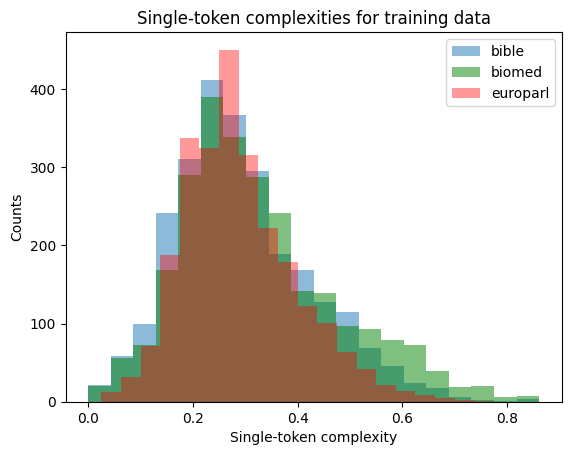

In [77]:
plt.hist(single_train_bible_complexities, bins=20, alpha=0.5, label='bible')
plt.hist(single_train_biomed_complexities, bins=20, alpha=0.5, color='g', label='biomed')
plt.hist(single_train_europarl_complexities, bins=20, alpha=0.4, color='r', label='europarl')
plt.legend(loc='upper right')
plt.xlabel('Single-token complexity')
plt.ylabel('Counts')
plt.title('Single-token complexities for training data')
plt.show()

# **Multi-word complexity training data metrics**

Complexities for single-word and multi-word expressions were measured by human annotators according to the following scale:

1) Very Easy: Words which were very familiar to an
annotator.

2) Easy: Words with which an annotator was aware
of the meaning.

3)Neutral: A word which was neither difficult nor
easy.

4)Difficult: Words which an annotator was unclear
of the meaning, but may have been able to
infer the meaning from the sentence.

5) Very Difficult: Words that an annotator had never
seen before, or were very unclear.


The scores of 1 to 5 were then converted to a scale ranging from 0 to 1 as below, then averaged for all annotators who rated the sentence:

1 -> 0

2 -> 0.25

3 -> 0.5

4 -> 0.75

5 -> 1


---

For the multi-word task, we also see the biomed corpus having token complexity with greater mean/median/std dev than the bible and europarl corpuses. Here, though, the differences are much more pronounced.

In [50]:
multi_train_bible_complexities = multi_train_df.iloc[bible_multi_train_idx]['complexity']
multi_train_biomed_complexities = multi_train_df.iloc[biomed_multi_train_idx]['complexity']
multi_train_europarl_complexities = multi_train_df.iloc[europarl_multi_train_idx]['complexity']

print("Multi-token Bible training data:\n  mean: " + 
      str(np.mean(multi_train_bible_complexities)) + "\n  median: " + 
      str(np.median(multi_train_bible_complexities)) + "\n  std dev: " + 
      str(np.std(multi_train_bible_complexities)))

print("\nMulti-token Biomed training data:\n  mean: " + 
      str(np.mean(multi_train_biomed_complexities)) + "\n  median: " + 
      str(np.median(multi_train_biomed_complexities)) + "\n  std dev: " + 
      str(np.std(multi_train_biomed_complexities)))

print("\nMulti-token Europarl training data:\n  mean: " + 
      str(np.mean(multi_train_europarl_complexities)) + "\n  median: " + 
      str(np.median(multi_train_europarl_complexities)) + "\n  std dev: " + 
      str(np.std(multi_train_europarl_complexities)))

Multi-token Bible training data:
  mean: 0.3770950792451919
  median: 0.375
  std dev: 0.1464818503693899

Multi-token Biomed training data:
  mean: 0.49369291084122174
  median: 0.525
  std dev: 0.17120809289536934

Multi-token Europarl training data:
  mean: 0.3824566213007995
  median: 0.368421052631579
  std dev: 0.11294854850918006


The complexities from the biomed corpus are distributed noticeably differently than those from the bible and europarl corpuses. 

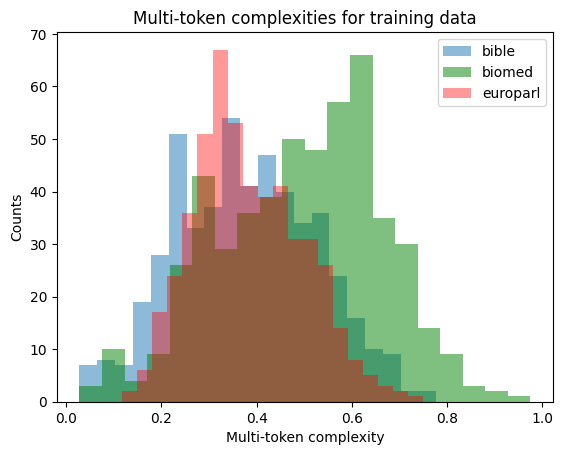

In [78]:
plt.hist(multi_train_bible_complexities, bins=20, alpha=0.5, label='bible')
plt.hist(multi_train_biomed_complexities, bins=20, alpha=0.5, color='g', label='biomed')
plt.hist(multi_train_europarl_complexities, bins=20, alpha=0.4, color='r', label='europarl')
plt.legend(loc='upper right')
plt.xlabel('Multi-token complexity')
plt.ylabel('Counts')
plt.title('Multi-token complexities for training data')
plt.show()

# **Input structure for encoder**

A brief overview of how data is incorporated into neural network models in the other notebooks

The 'sentence' and 'token' column values for each row are tokenized and "packed" into a single input string before encoding and being input to the BERT layer. Inputs are padded to a max length of 128 (generally enough to include longer input strings from the data). 

Tokenized input format:

`[CLS] tokenized sentence column value [SEP] tokenized token column value [SEP] [PAD] [PAD] [PAD] ...`



In [86]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Single-token task example input

In [99]:
encoding_example = tokenizer(single_train_df.iloc[0]['sentence'], single_train_df.iloc[0]['token'], padding="max_length", max_length=128, truncation=True)
tokenizer.decode(encoding_example['input_ids'])

'[CLS] behold, there came up out of the river seven cattle, sleek and fat, and they fed in the marsh grass. [SEP] river [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

Multi-token task example input

In [100]:
encoding_example = tokenizer(multi_train_df.iloc[0]['sentence'], multi_train_df.iloc[0]['token'], padding="max_length", max_length=128, truncation=True)
tokenizer.decode(encoding_example['input_ids'])

'[CLS] but the seventh day is a sabbath to yahweh your god, in which you shall not do any work, you, nor your son, nor your daughter, nor your male servant, nor your female servant, nor your ox, nor your donkey, nor any of your livestock, nor your stranger who is within your gates ; that your male servant and your female servant may rest as well as you. [SEP] seventh day [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

# **Classifier model high-level description**

A high-level depiction of the code used for BERT and other model fine-tunings. Data is tokenized and packed as in the preprocessing step defined above, then fed into a Keras model that incodes the input, feeds it through a pre-trained model, sends the encoder model "pooled output" through a dropout layer, then a dense layer with sigmoid activation to output a value between 0 and 1. The model is fine-tuned based on a loss metric and optimizer set by the user.

In [118]:
def build_regression_model():

  class Regression(tf.keras.Model):
    def __init__(self):
      super(Regression, self).__init__(name="prediction")
      self.encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=True)
      self.dropout = tf.keras.layers.Dropout(0.1)
      self.dense = tf.keras.layers.Dense(1, activation='sigmoid', name="output")

    def call(self, preprocessed_text):
      encoder_outputs = self.encoder(preprocessed_text)
      pooled_output = encoder_outputs["pooled_output"]
      x = self.dropout(pooled_output)
      x = self.dense(x)
      return x

  model = Regression()
  return model

In [79]:
preprocess = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1')
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=True)

In [113]:
encoder_inputs_example = preprocess.bert_pack_inputs([preprocess.tokenize([single_train_df.iloc[0]['sentence']]), preprocess.tokenize([single_train_df.iloc[0]['token']])])
outputs_example = tf.convert_to_tensor([single_train_df.iloc[0]['complexity']])

In [119]:
model = build_regression_model()
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.MeanSquaredError()],
)

In [120]:
history = model.fit(encoder_inputs_example, outputs_example)

1/1 [==============================] - 39s 39s/step - loss: 0.1934 - mean_squared_error: 0.1934


In [121]:
model.summary()

Model: "prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  multiple                  109482241 
                                                                 
 dropout_3 (Dropout)         multiple                  0         
                                                                 
 output (Dense)              multiple                  769       
                                                                 
Total params: 109,483,010
Trainable params: 109,483,009
Non-trainable params: 1
_________________________________________________________________
